In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from importlib import reload
import os
from os.path import join
import subprocess
import sys
sys.path.append('../../') # lets us import ptype package from the subdir
#import ptype.
import time

import soundings.utils as utils
import soundings.mr_analysis as mra
from soundings.mr_analysis import SoundingQuery

In [2]:
data_dir = "/glade/work/dkimpara/ptype-aggs"
model = 'rap'
select_case = {'case_study_day': 'kentucky-20220224',
               #'init_hr': [0,2],
              }
#which profiles to plot
proftypes = ['t_h', 'dpt_h','wb_h']


ds = xr.open_dataset(join(data_dir,f"{model}_all.nc"), engine='netcdf4')
query = SoundingQuery(ds)
lstyledict = {'t_h': 'solid',
              'dpt_h': 'dashed',
              'wb_h': 'dotted'}


# mean soundings

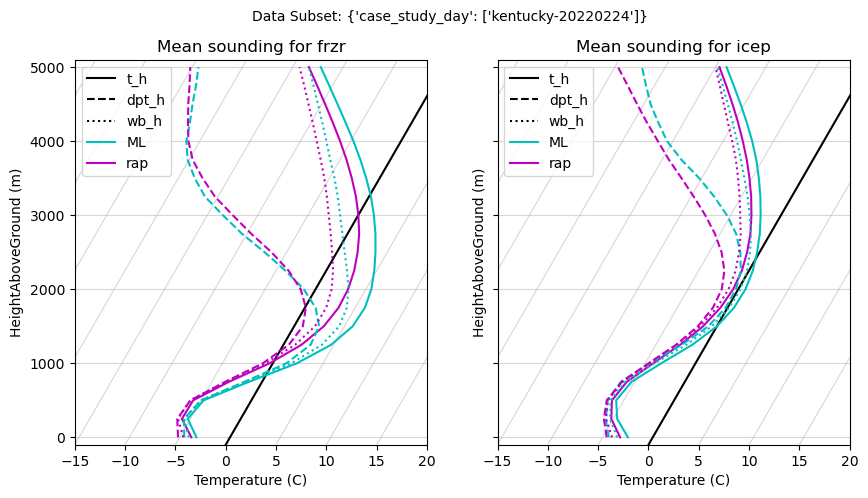

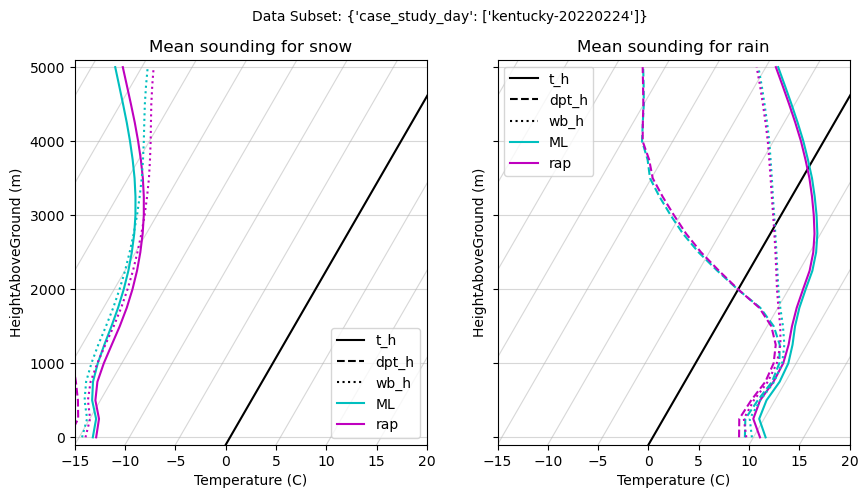

In [3]:
bad = ['cfrzr', 'cicep']
good = ['csnow', 'crain']
allptypes = [bad,good]
h = ds.heightAboveGround

for pair in allptypes:
    fig, axs = utils.skewCompositeFigAx(figsize=(10,7),num_subplots=2)
    for i, ptype in enumerate(pair):
        ml = query.query(['ML_' + ptype], ['t_h', 'dpt_h','wb_h'], 'mean', select_case)
        nwp = query.query([ptype], ['t_h', 'dpt_h','wb_h'], 'mean', select_case)
        ax = axs[i]
        for var in lstyledict.keys():
            ax.plot(ml[f'{var}_mean'].values.flatten(), h, color='c', linestyle=lstyledict[var])
            ax.plot(nwp[f'{var}_mean'].values.flatten(), h, color='m', linestyle=lstyledict[var])
            line, = ax.plot([],[], color='0', linestyle=lstyledict[var])
            line.set_label(var)
        
        ml = query.query(['ML_' + ptype], ['t_h', 'dpt_h','wb_h'], ['fabv'])
        nwp = query.query([ptype], ['t_h', 'dpt_h','wb_h'], ['fabv'])
        '''
        text = [[f"{data[f'{var}_fabv'].values[0]:.2f}" for var in proftypes] for data in [ml, nwp]]
        
        ax.table(cellText=text,
                  #rowLabels=[f'ML\nNum Obs:{ml.num_obs.values}', 
                   #          f'{model}\nNum Obs:{nwp.num_obs.values}'],
                  rowLabels=['ML', model],
                  colLabels=[f'{var} frac abv 0' for var in proftypes],
                  loc='bottom'_
        '''
        ax.set_title(f'Mean sounding for {ptype[1:]}')
        ax.set_xlim(-15,20)
        ax.set_xlabel('Temperature (C)')
        ax.set_ylabel('HeightAboveGround (m)')
        line, = ax.plot([],[], color='c')
        line.set_label('ML')
        line, = ax.plot([],[], color='m')
        line.set_label(model)

        ax.legend()
    fig.suptitle(f'Data Subset: {select_case}', fontsize=10)


# mean vs median

## code

In [8]:
def meanvsmed(forecaster):
    h = ds.heightAboveGround
    for pair in allptypes:
        fig, axs = utils.skewCompositeFigAx(figsize=(10,5),num_subplots=2)
        for i, ptype in enumerate(pair):
            predtype= forecaster + ptype
            mean=  query.query([predtype], ['t_h', 'dpt_h','wb_h'], 'mean', select_case)
            qs = query.quantile(0.5, predtype, ['t_h', 'dpt_h','wb_h'], select_case)
            ax = axs[i]
            for var in lstyledict.keys():
                ax.plot(mean[f'{var}_mean'].values.flatten(), h, color='#1F77B4', linestyle=lstyledict[var])
                #ax.plot(nwp[f'{var}_mean'].values.flatten(), h, color='m', linestyle=lstyledict[var])
                ax.plot(qs[f'{var}_q'].values.flatten(), h, 
                        color='#FF7F0E', linestyle=lstyledict[var])
                #ax.plot(nwp_q[f'{var}_q'].values.flatten(), h, 
                       # marker = '+', color='m', linestyle=lstyledict[var])



                line, = ax.plot([],[], color='0', linestyle=lstyledict[var])
                line, = ax.plot([],[], color='0', linestyle=lstyledict[var])
                line.set_label(var)
            line, = ax.plot([],[], color='#FF7F0E')
            line.set_label('quantile')
            line, = ax.plot([],[], color='#1F77B4')
            line.set_label('mean')
            ax.set_title(f'Median against Mean Sounding\nfor {predtype} on {model} data')
            ax.set_xlim(-15,20)
            ax.set_xlabel('Temperature (C)')
            ax.set_ylabel('HeightAboveGround (m)')

            ax.legend()
        fig.suptitle(f'Data Subset: {select_case}', fontsize=10)

## plots

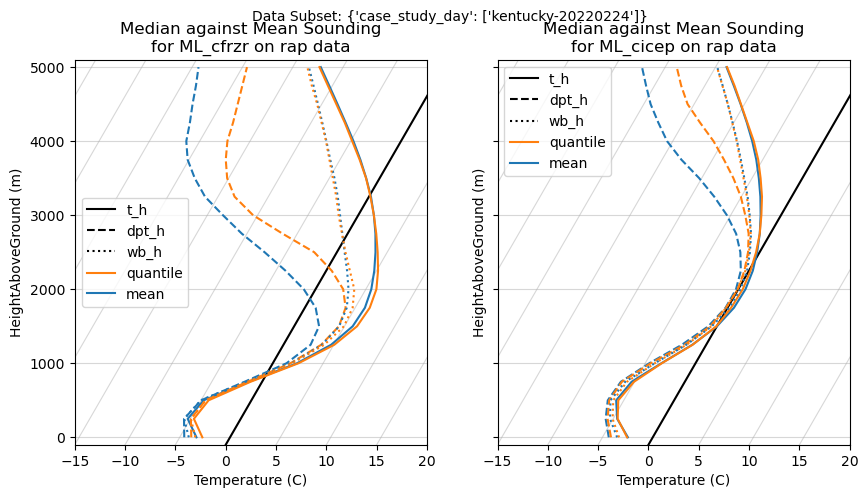

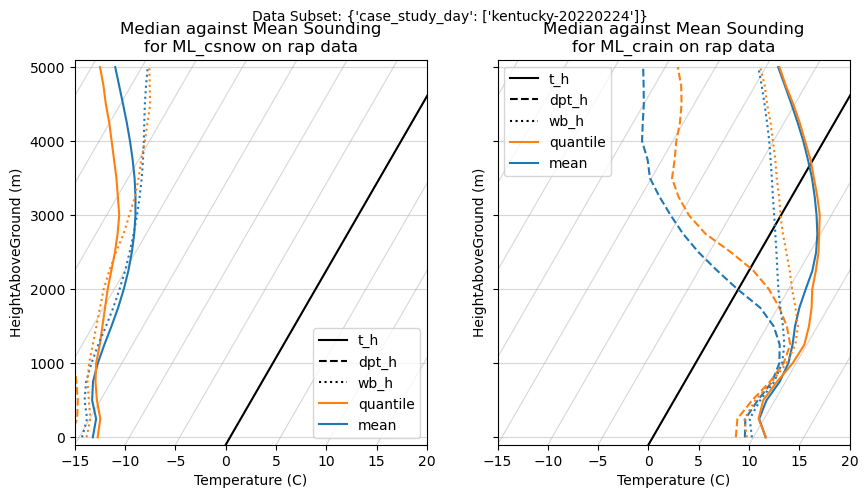

In [9]:
forecaster='ML_'
meanvsmed(forecaster)

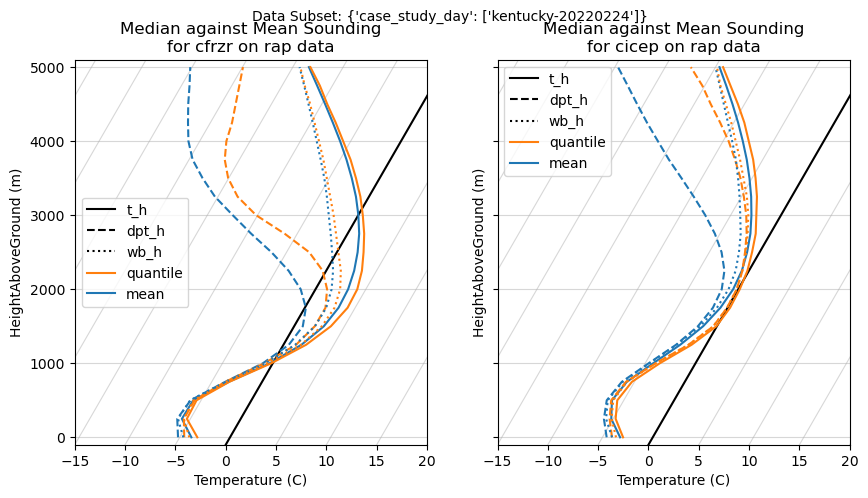

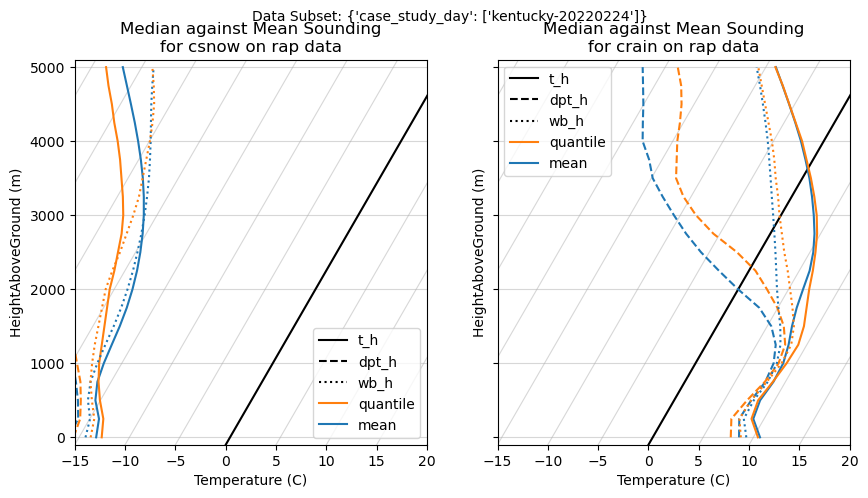

In [10]:
#empty str for nwp
forecaster=''
meanvsmed(forecaster)

# plot quantiles

In [5]:
#quantiles need to be odd in len and include 0.5

var = 't_h'
quantiles = np.arange(0.1,0.91,0.4)
half_quantiles = np.arange(0.1,0.41,0.4)
num_q = len(half_quantiles)

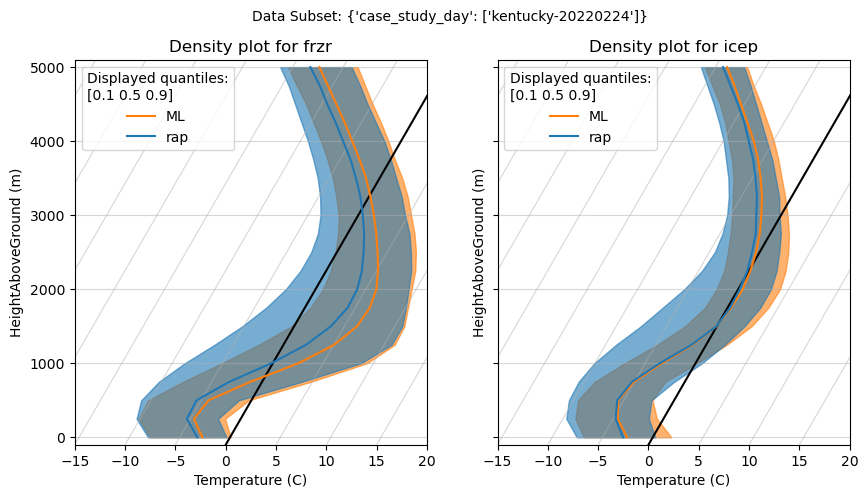

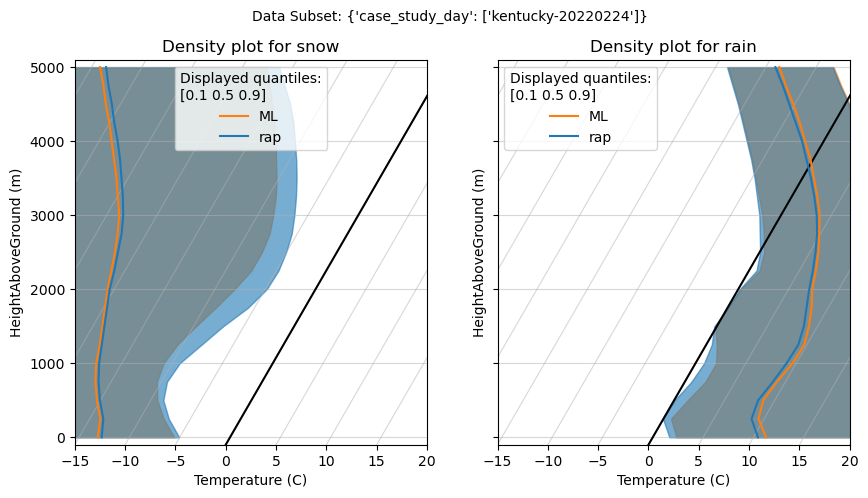

In [6]:
bad = ['cfrzr', 'cicep']
good = ['csnow', 'crain']
allptypes = [bad,good]
h = ds.heightAboveGround


for pair in allptypes:
    fig, axs = utils.skewCompositeFigAx(figsize=(10,5),num_subplots=2)
    for ax, ptype in zip(axs, pair):
        ml = query.quantile(quantiles, ['ML_' + ptype], var, select_case)
        nwp = query.quantile(quantiles, ptype, var, select_case)
        
        for data, color in zip([ml,nwp], ['#FF7F0E','#1F77B4']):
            for i in range(num_q):
                lowerq = data[f'{var}_q'].sel(quantile=quantiles[i]).values.flatten()
                upperq = data[f'{var}_q'].sel(quantile=quantiles[-(i + 1)]).values.flatten()
                ax.fill_betweenx(h, lowerq, upperq, alpha=0.6, color=color)
            ax.plot(data[f'{var}_q'].sel(quantile=0.5, method='nearest').values.flatten(), h, color=color)

        ax.set_title(f'Density plot for {ptype[1:]}')
        ax.set_xlim(-15,20)
        ax.set_xlabel('Temperature (C)')
        ax.set_ylabel('HeightAboveGround (m)')
        line, = ax.plot([],[], color='#FF7F0E')
        line.set_label('ML')
        line, = ax.plot([],[], color='#1F77B4')
        line.set_label(model)

        ax.legend(title=f'Displayed quantiles:\n{quantiles}')
    fig.suptitle(f'Data Subset: {select_case}', fontsize=10)

        